In [603]:
import numpy as np
import networkx as nx
from networkx.algorithms.cycles import find_cycle
from networkx.exception import NetworkXNoCycle
from networkx.algorithms.dag import is_directed_acyclic_graph

# rows are comma-separated
def row_inp_to_array(inp):
    return np.array([int(i) for i in inp.split(',')])

def setup():
    n = int(input('number of players:'))
    assert n > 0, 'must be a positive integer'

    t = int(input('number of item types:'))
    assert t > 0,  'must be a positive integer'

    items = row_inp_to_array(input('number of items of each type:'))
    assert len(items) == t, 'must be of length t=' + str(t)

    valuations = np.zeros((n,t))
    for i in range(n):
        val_row = row_inp_to_array(input('valuation for player ' + str(i+1) + ':'))
        assert len(val_row) == t, 'must be of length t=' + str(t)
        valuations[i,:] = val_row
    
    assignments = np.zeros((n,t))
    return n, t, assignments, items, valuations

#envy-freeness
def get_bundle_values(assignments, valuations, j):
    return assignments.dot(valuations[j])

def check_ef(assignments, valuations, j):
    bundle_values = get_bundle_values(assignments, valuations, j)
    return j in np.flatnonzero(bundle_values == np.max(bundle_values))

def check_efx(assignments, valuations, j):
    if check_ef(assignments, valuations, j):
        return True
    bundle_values = get_bundle_values(assignments, valuations, j)
    # EFX: for every item type:
    for i in range(len(assignments[0])):
        amt_of_type_i = np.copy(assignments[:, i])
        without_1 = np.copy(amt_of_type_i)
        
        # just consider nonzero bundles and j
        mask = list(np.flatnonzero(amt_of_type_i))
        if j not in mask:
            mask.append(j)
        
        # of nonzero bundles, remove an item
        without_1[mask] -= 1
        # dont subtract one from the current player
        without_1[j] = amt_of_type_i[j]
        # should be EF among nonzero items
        assignments[:, i] = without_1
        is_ef = check_ef(assignments[mask, :], valuations[mask, :], mask.index(j))
        assignments[:, i] = amt_of_type_i
        if not is_ef:
            return False
    return True

def check_all_ef(assignments, valuations):
    return check_all(assignments, valuations, check_ef)

def check_all_efx(assignments, valuations):
    return check_all(assignments, valuations, check_efx)

def check_all(assignments, valuations, fn):
    for j in range(len(assignments)):
        if not fn(assignments, valuations, j):
            return False
    return True 

def check_all_done(assignments, items):
    return np.all(np.sum(assignments, axis=0) == items)

def item_type_available(assignments, items, i):
    return np.sum(assignments[:, i]) < items[i]

def run_u0_if_possible(n, t, assignments, items, valuations):
    item_order = np.arange(t)
    for i in item_order:
        if item_type_available(assignments, items, i):
            player_order = np.arange(n)
            for j in player_order:
                assignments[j,i] += 1
                if check_all_efx(assignments, valuations):
                    return True, assignments
                assignments[j,i] -= 1
    return False, assignments

def create_envy_digraph(assignments, valuations, n):
    envy_edges = np.zeros((n, n))
    for i in range(n):
        row = assignments.dot(valuations[i])
        envy_edges[i, :] = row > row[i]
    return nx.DiGraph(envy_edges)

def locate_envy_cycle(G):
    try:
        cycle = find_cycle(G)
        return True, cycle
    except NetworkXNoCycle:
        return False, None

def run():
    # setup
    n, t, assignments, items, valuations = setup()
    print(assignments.shape)
    # algorithm
    while True:
        # assert partial EFX
        assert check_all_efx(assignments, valuations), "this should be partial EFX"
        # de cycle graph if needed
        G = create_envy_digraph(assignments, valuations, n)
        is_cycle, cycle = locate_envy_cycle(G)
        while is_cycle:
            print("DE-CYCLING GRAPH")
            cycle_mask = [e[0] for e in locate_envy_cycle(G)[1]]
            cycle_mask_new = cycle_mask[1:] + cycle_mask[0:1]
            assignments[cycle_mask_new] = assignments[cycle_mask]
            G = create_envy_digraph(assignments, valuations, n)
            is_cycle, cycle = locate_envy_cycle(G)
        assert is_directed_acyclic_graph(G)
        # check if done
        if check_all_done(assignments, items):
            print("DONE")
            return n, t, assignments, items, valuations
        # run U0 if possible
        success, assignments = run_u0_if_possible(n, t, assignments, items, valuations)
        if success:
            print("APPLIED U0")
            continue
        print("COULD NOT APPLY U0")
        # run U2 if possible
        print("TODO APPLY U2")
        print("COULD NOT APPLY U2 (!)")
        return n, t, assignments, items, valuations

In [604]:
n, t, assignments, items, valuations = run()
for idx,row in enumerate(assignments):
    print('player', idx+1, 'assignments:', row)
assert check_all_efx(assignments, valuations), "EFX SHOULD HOLD"
assert check_all_done(assignments, items), "ALL ITEMS SHOULD BE ALLOCATED"

number of players: 3
number of item types: 2
number of items of each type: 2,3
valuation for player 1: 1,5
valuation for player 2: 2,5
valuation for player 3: 4,2


(3, 2)
APPLIED U0
APPLIED U0
APPLIED U0
DE-CYCLING GRAPH
APPLIED U0
APPLIED U0
DONE
player 1 assignments: [0. 2.]
player 2 assignments: [1. 1.]
player 3 assignments: [1. 0.]


# development area

In [ ]:
# u2 rule
# find a source (unenvied player)
# then choose an item type to add
# add it to the source
# we know because u0 failed, that we can find a most envious agent
# we have freedom on which items to remove (but cannot remove the type we gave since it's a source)
# let's just remove them in order for now
# at every step, we check if someone envies it
# once we run out, we use a different one to remove
# if there is no more enviers, then go back one and try removing the next type
# once we are on the last type, when we run out, we go back one
# then choose one of the enviers
# that is our t0

In [404]:
n, t, assignments, items, valuations = setup()

number of players: 2
number of item types: 2
number of items of each type: 1,5
valuation for player 1: 5,5
valuation for player 2: 1,100


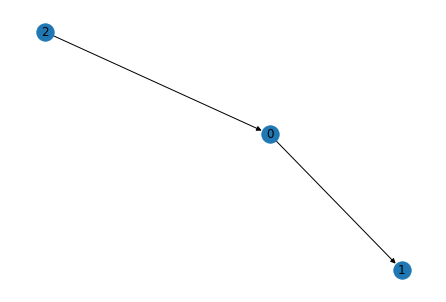

In [560]:
G = create_envy_digraph(assignments, valuations, n)
nx.draw(G, with_labels=True)